In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
import pickle
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_theme(style="whitegrid")

# Descargar recursos NLTK
nltk.download(['punkt', 'stopwords', 'wordnet'])

[nltk_data] Downloading package punkt to /Users/deka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/deka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/deka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Cargar el dataset
df = pd.read_csv('/Users/deka/Desktop/Apps/ProyectoM7/data/raw/googleplaystore_user_reviews.csv')

print("=== Estado inicial de los datos ===")
print(f"Número total de filas: {len(df)}")
print("\nValores nulos por columna:")
print(df.isnull().sum())

=== Estado inicial de los datos ===
Número total de filas: 64295

Valores nulos por columna:
App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64


In [4]:
# Limpieza inicial: eliminar filas con valores nulos en columnas críticas
df = df.dropna(subset=['Translated_Review', 'Sentiment_Polarity'])
print("\n=== Después de eliminar nulos ===")
print(f"Número de filas restantes: {len(df)}")

# Funciones de limpieza
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else "no_text"

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens) if tokens else "no_text"

# Aplicar limpieza y preprocesamiento
print("\n=== Aplicando preprocesamiento ===")
df['Cleaned_Review'] = df['Translated_Review'].apply(clean_text)
df['Processed_Review'] = df['Cleaned_Review'].apply(preprocess_text)

# Crear etiquetas de sentimiento
df['Sentiment'] = pd.cut(df['Sentiment_Polarity'], 
                        bins=[-1, -0.1, 0.1, 1], 
                        labels=['Negative', 'Neutral', 'Positive'])


=== Después de eliminar nulos ===
Número de filas restantes: 37427

=== Aplicando preprocesamiento ===


In [5]:
# Verificar que no hay valores nulos después del procesamiento
print("\n=== Verificación final de valores nulos ===")
print(df[['Processed_Review', 'Sentiment']].isnull().sum())

# Eliminar cualquier fila que aún tenga valores nulos
df = df.dropna(subset=['Processed_Review', 'Sentiment'])


=== Verificación final de valores nulos ===
Processed_Review      0
Sentiment           234
dtype: int64



=== Distribución de sentimientos ===
Sentiment
Positive    20579
Neutral     11010
Negative     5604
Name: count, dtype: int64


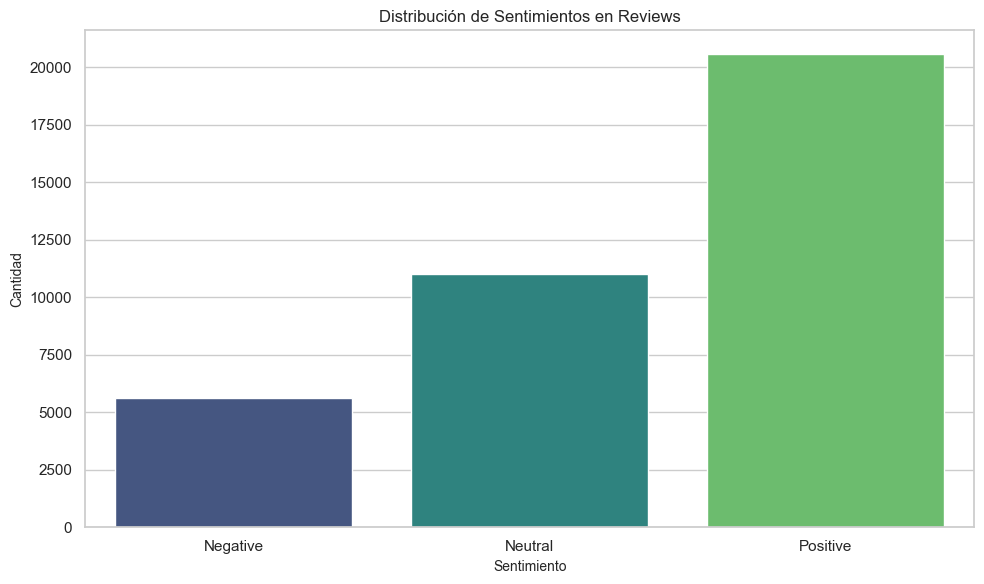

In [6]:
# Visualización de la distribución de sentimientos
plt.figure(figsize=(10, 6))
sentiment_counts = df['Sentiment'].value_counts()
print("\n=== Distribución de sentimientos ===")
print(sentiment_counts)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribución de Sentimientos en Reviews', fontsize=12)
plt.xlabel('Sentimiento', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)
plt.tight_layout()
plt.show()

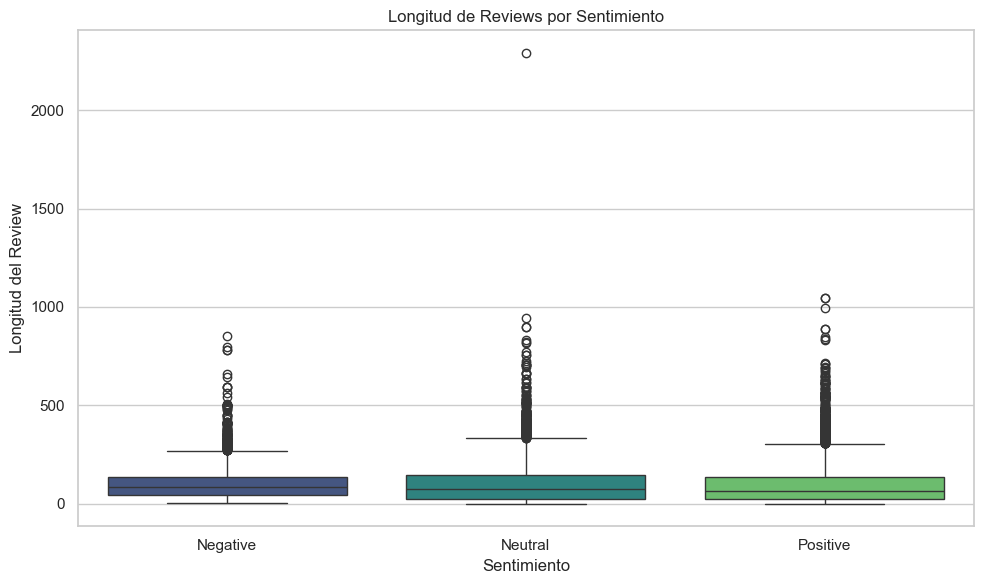

In [7]:
# Análisis de longitud
df['Review_Length'] = df['Processed_Review'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Review_Length', data=df, palette='viridis')
plt.title('Longitud de Reviews por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Longitud del Review')
plt.tight_layout()
plt.show()

In [8]:
# Vectorización y división de datos
print("\n=== Preparando datos para el modelo ===")
# Verificar que tenemos texto en todas las reviews
df['Processed_Review'] = df['Processed_Review'].replace('', 'no_text')
print(f"Reviews vacías: {(df['Processed_Review'] == 'no_text').sum()}")

# Vectorización
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Processed_Review'])
y = df['Sentiment']

# Verificar que no hay valores nulos antes de la división
assert not np.any(pd.isnull(y)), "Hay valores nulos en y"
print("Verificación de nulos completada")

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Guardar datos procesados
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'vectorizer': vectorizer
}

with open('processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)


=== Preparando datos para el modelo ===
Reviews vacías: 54
Verificación de nulos completada


In [9]:
# Imprimir dimensiones finales
print("\n=== Dimensiones finales ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


=== Dimensiones finales ===
X_train shape: (29754, 5000)
X_test shape: (7439, 5000)
y_train shape: (29754,)
y_test shape: (7439,)


In [10]:
# Análisis de características
print("\n=== Top 20 términos más frecuentes ===")
feature_names = vectorizer.get_feature_names_out()
sums = X.sum(axis=0).A1
top_features_idx = sums.argsort()[-20:][::-1]
for idx in top_features_idx:
    print(f"{feature_names[idx]}: {sums[idx]:.2f}")


=== Top 20 términos más frecuentes ===
good: 1393.79
game: 1264.47
love: 1021.67
great: 961.92
like: 818.86
app: 708.42
time: 682.71
nice: 640.09
get: 613.33
work: 588.17
ad: 554.77
easy: 496.89
really: 489.03
best: 468.88
cant: 466.90
update: 436.22
would: 428.83
much: 411.41
need: 410.03
make: 398.78


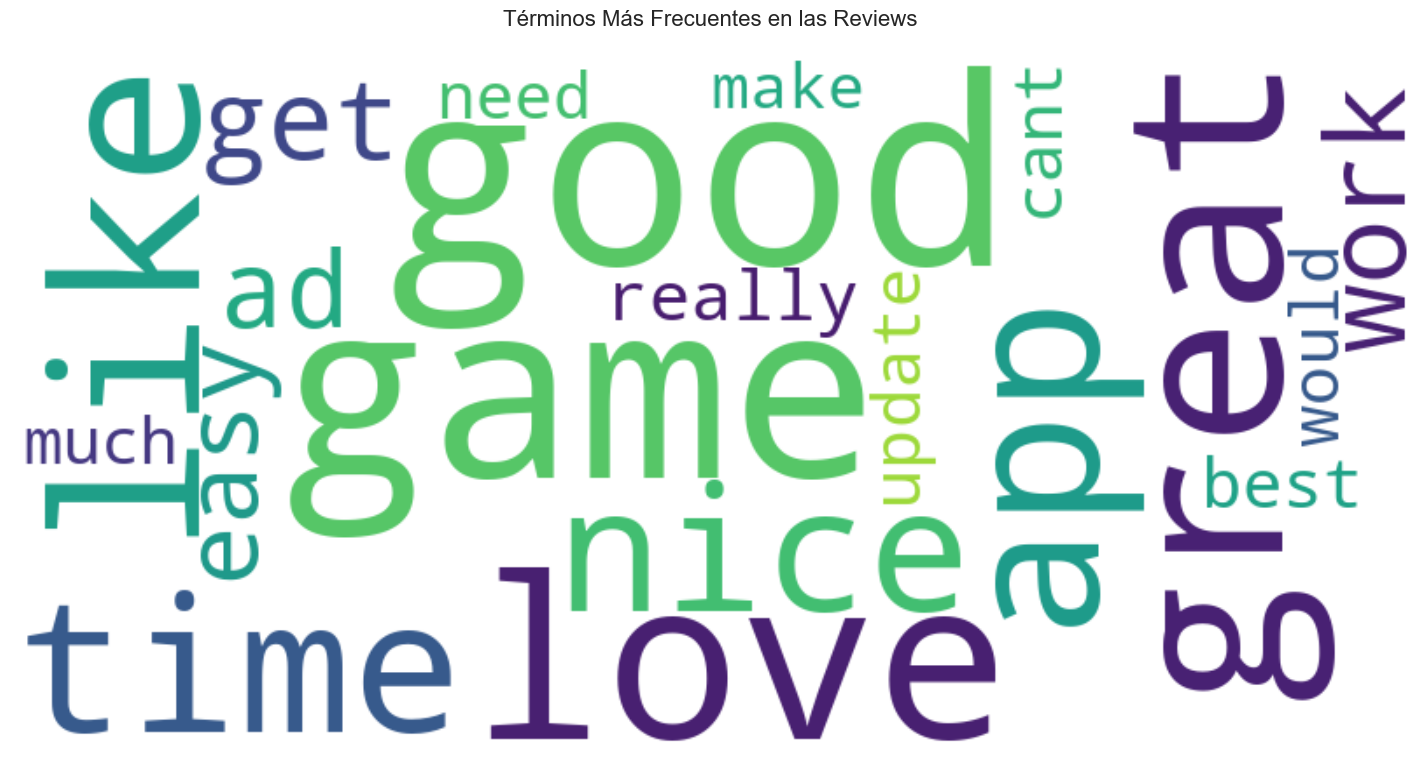

In [11]:
# Crear la nube de palabras
word_freq = {feature_names[idx]: sums[idx] for idx in top_features_idx}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    prefer_horizontal=0.7,  # 70% de palabras horizontales
    max_words=20,
    min_font_size=10,
    max_font_size=150,
    random_state=42
)

# Generar la nube de palabras
wordcloud.generate_from_frequencies(word_freq)

# Crear la visualización
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Términos Más Frecuentes en las Reviews', 
          fontsize=16, 
          pad=20)

# Añadir un borde sutil
plt.gca().set_frame_on(True)
plt.gca().patch.set_alpha(0)
plt.gca().set_frame_on(True)
plt.gca().patch.set_edgecolor('lightgray')
plt.gca().patch.set_linewidth(2)

plt.tight_layout(pad=3)
plt.show()

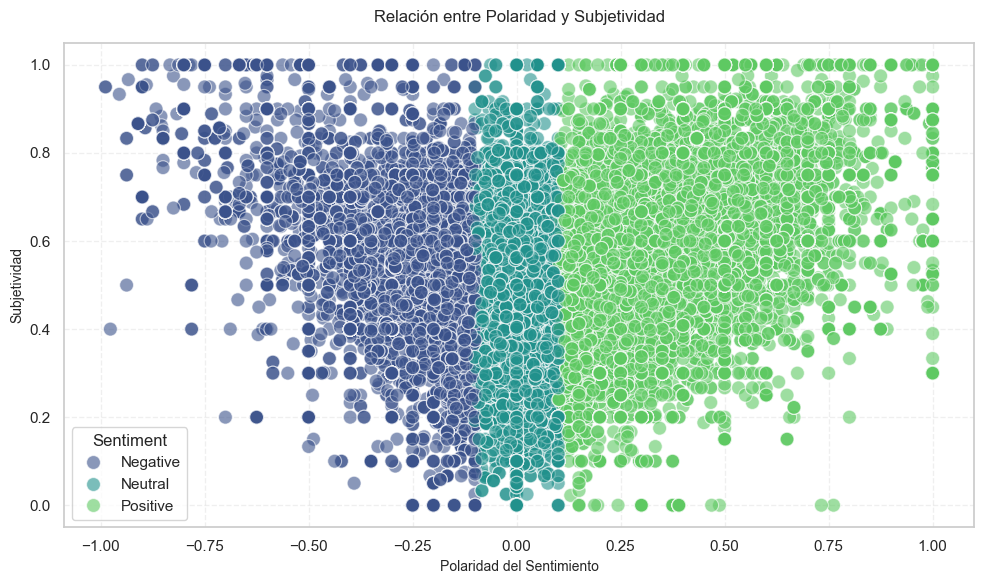

In [12]:
# Análisis de Subjetividad vs Polaridad
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Sentiment_Polarity',
    y='Sentiment_Subjectivity',
    hue='Sentiment',
    palette='viridis',  
    alpha=0.6,
    s=100
)

# Personalizar el gráfico
plt.title('Relación entre Polaridad y Subjetividad', fontsize=12, pad=15)
plt.xlabel('Polaridad del Sentimiento', fontsize=10)
plt.ylabel('Subjetividad', fontsize=10)

# Añadir grid sutil
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

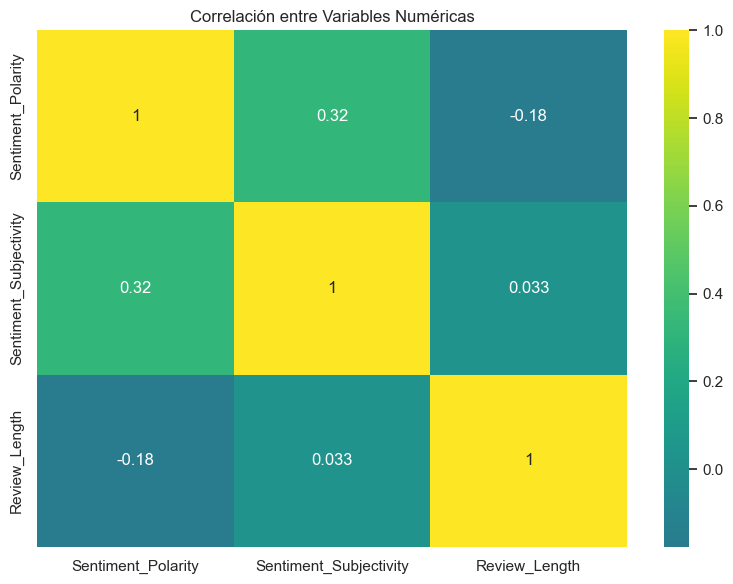

In [13]:
# Correlación entre variables numéricas
numeric_cols = ['Sentiment_Polarity', 'Sentiment_Subjectivity', 'Review_Length']
correlation = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='viridis', center=0)
plt.title('Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()

In [14]:
# Guardar datos procesados
OUTPUT_PATH = '/Users/deka/Desktop/Apps/ProyectoM7/data/processed/processed_reviews.csv'
df.to_csv(OUTPUT_PATH, index=False)
print(f"\nDatos procesados guardados en {OUTPUT_PATH}")


Datos procesados guardados en /Users/deka/Desktop/Apps/ProyectoM7/data/processed/processed_reviews.csv
